In [2]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [14]:
def process_files_in_directory(directory, threshold_percentage=20):
    summary_results = []  
    for file_name in os.listdir(directory):
        file_path = os.path.join(directory, file_name)
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path)
            df = categorize_answer_location(df, threshold_percentage)
            
            total_counts = df['answer_loc'].value_counts().to_dict()
            correct_counts = df[df['is_correct']]['answer_loc'].value_counts().to_dict()
            
            for loc in ['beginning', 'middle', 'end', 'unknown']:
                if loc not in total_counts:
                    total_counts[loc] = 0
                if loc not in correct_counts:
                    correct_counts[loc] = 0
            
            model, format_type, style = extract_details(file_name)
            
            summary_results.append({
                'file_name': file_name,
                'model': model,
                'format': format_type,
                'style': style,
                'total_beginning': total_counts['beginning'],
                'correct_beginning': correct_counts['beginning'],
                'total_middle': total_counts['middle'],
                'correct_middle': correct_counts['middle'],
                'total_end': total_counts['end'],
                'correct_end': correct_counts['end'],
                'total_unknown': total_counts['unknown'],
                'correct_unknown': correct_counts['unknown']
            })
    
    summary_df = pd.DataFrame(summary_results)
    return summary_df


In [15]:
def categorize_answer_location(df, threshold_percentage=20):
    answer_locations = []
    correct = []

    for index, row in df.iterrows():
        generation = row['raw_generation']
        correct_answer = row['correct_answer']
        match = re.search(r'<ans>(.*?)</ans>', generation)
        
        if match:
            start_pos = match.start()
            total_length = len(generation)
            beginning_threshold = total_length * (threshold_percentage / 100)
            end_threshold = total_length * (1 - (threshold_percentage / 100))
            
            if start_pos < beginning_threshold:
                answer_locations.append('beginning')
            elif start_pos >= end_threshold:
                answer_locations.append('end')
            else:
                answer_locations.append('middle')
            
            parsed_answer = match.group(1).strip()
            correct.append(parsed_answer == correct_answer)
        else:
            answer_locations.append('unknown')
            correct.append(False)

    df['answer_loc'] = answer_locations
    df['is_correct'] = correct
    
    return df


In [16]:
def extract_details(file_name):
    match = re.match(r'story_analogies_far_(.*?)[0-9]*_prompt_templates-story_analogies-(.*?)-([0-9]+).csv', file_name)
    if match:
        model, format_type, style = match.groups()
        # Further split the format into main format and forced/not forced part
        format_split = format_type.split('_')
        if len(format_split) > 1:
            main_format = f"{format_split[0]}_{format_split[1]}"
        else:
            main_format = format_split[0]
        return model, main_format, style
    return None, None, None

directory_path = 'results/story_far_all_prompts'  # Update this path to your directory

summary_df = process_files_in_directory(directory_path, 20)

print(summary_df)

                                            file_name            model  \
0   story_analogies_far_starling7b-beta_prompt_tem...  starling7b-beta   
1   story_analogies_far_starling7b-beta_prompt_tem...  starling7b-beta   
2   story_analogies_far_starling7b-beta_prompt_tem...  starling7b-beta   
3   story_analogies_far_starling7b-beta_prompt_tem...  starling7b-beta   
4   story_analogies_far_starling7b-beta_prompt_tem...  starling7b-beta   
5   story_analogies_far_starling7b-beta_prompt_tem...  starling7b-beta   
6   story_analogies_far_mistral7b_prompt_templates...        mistral7b   
7   story_analogies_far_mistral7b_prompt_templates...        mistral7b   
8   story_analogies_far_mistral7b_prompt_templates...        mistral7b   
9   story_analogies_far_mistral7b_prompt_templates...        mistral7b   
10  story_analogies_far_mistral7b_prompt_templates...        mistral7b   
11  story_analogies_far_mistral7b_prompt_templates...        mistral7b   
12  story_analogies_far_starling7b-bet

In [12]:
summary_df.to_csv('summary_reason_results.csv', index=False)


In [3]:
file_path = 'reasoning_summary.csv'
data = pd.read_csv(file_path)

data = pd.read_csv(file_path)

data['correct_rate_beginning'] = data['correct_beginning'] / data['total_beginning']
data['correct_rate_middle'] = data['correct_middle'] / data['total_middle']
data['correct_rate_end'] = data['correct_end'] / data['total_end']

data['correct_rate_beginning'] = data['correct_rate_beginning'].fillna(0)
data['correct_rate_middle'] = data['correct_rate_middle'].fillna(0)
data['correct_rate_end'] = data['correct_rate_end'].fillna(0)

analysis_df = data[['model', 'format', 'style', 'correct_rate_beginning', 'correct_rate_middle', 'correct_rate_end']]

melted_df = pd.melt(analysis_df, id_vars=['model', 'format', 'style'], 
                    value_vars=['correct_rate_beginning', 'correct_rate_middle', 'correct_rate_end'], 
                    var_name='position', value_name='correct_rate')

/var/folders/3m/t6brtqlj0t5b6r2jgngv4gx00000gn/T/ipykernel_42118/1751544845.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='position', y='correct_rate', hue='model', data=melted_df, ci=None)


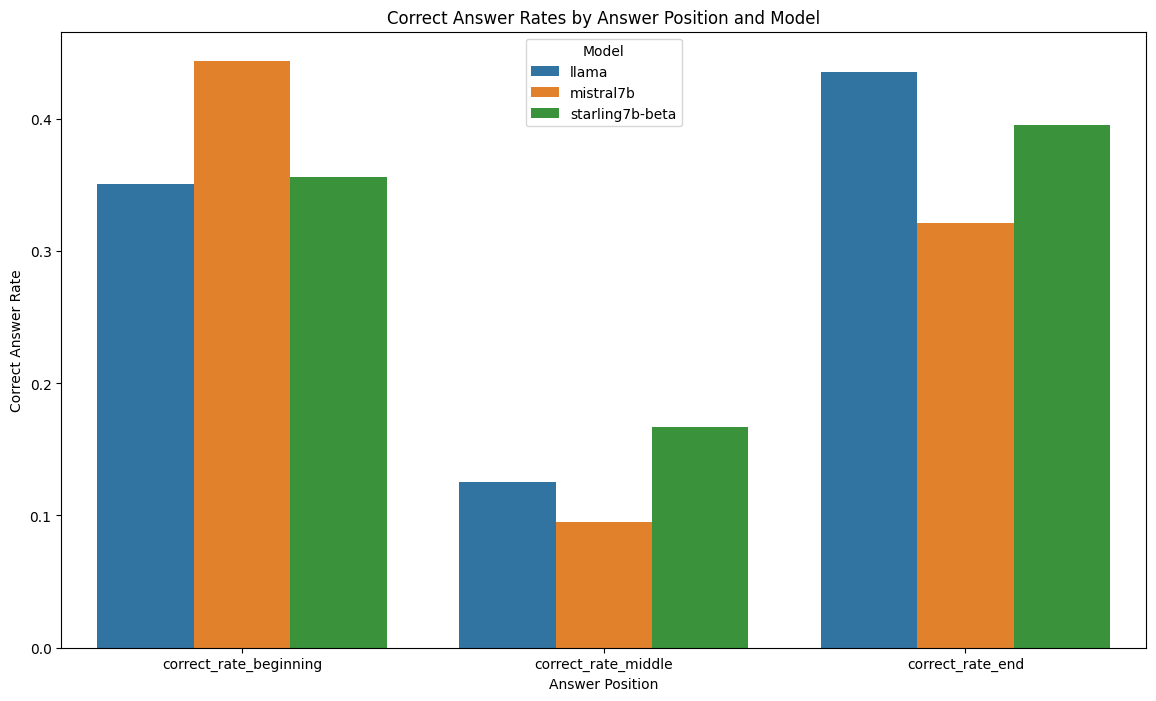

In [5]:


plt.figure(figsize=(14, 8))
sns.barplot(x='position', y='correct_rate', hue='model', data=melted_df, ci=None)
plt.title('Correct Answer Rates by Answer Position and Model')
plt.xlabel('Answer Position')
plt.ylabel('Correct Answer Rate')
plt.legend(title='Model')
plt.show()




/var/folders/3m/t6brtqlj0t5b6r2jgngv4gx00000gn/T/ipykernel_42118/1145051206.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='position', y='correct_rate', hue='format', data=melted_df, ci=None)


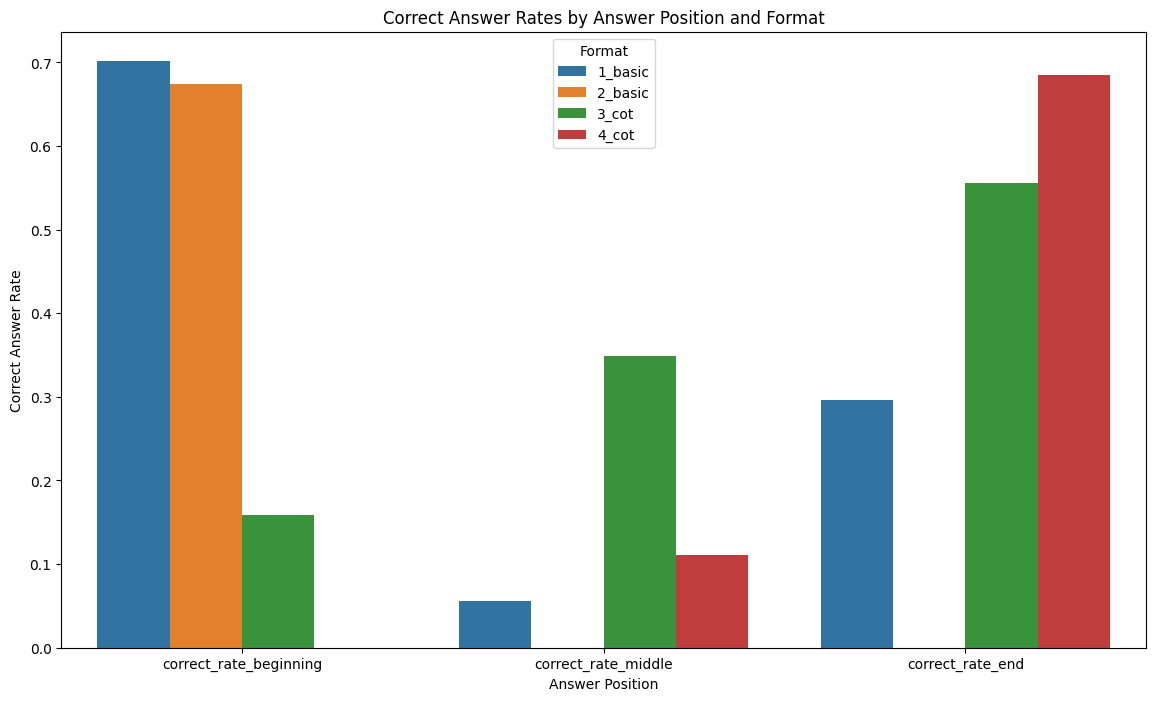

In [6]:
plt.figure(figsize=(14, 8))
sns.barplot(x='position', y='correct_rate', hue='format', data=melted_df, ci=None)
plt.title('Correct Answer Rates by Answer Position and Format')
plt.xlabel('Answer Position')
plt.ylabel('Correct Answer Rate')
plt.legend(title='Format')
plt.show()



/var/folders/3m/t6brtqlj0t5b6r2jgngv4gx00000gn/T/ipykernel_42118/2461886311.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='position', y='correct_rate', hue='style', data=melted_df, ci=None)


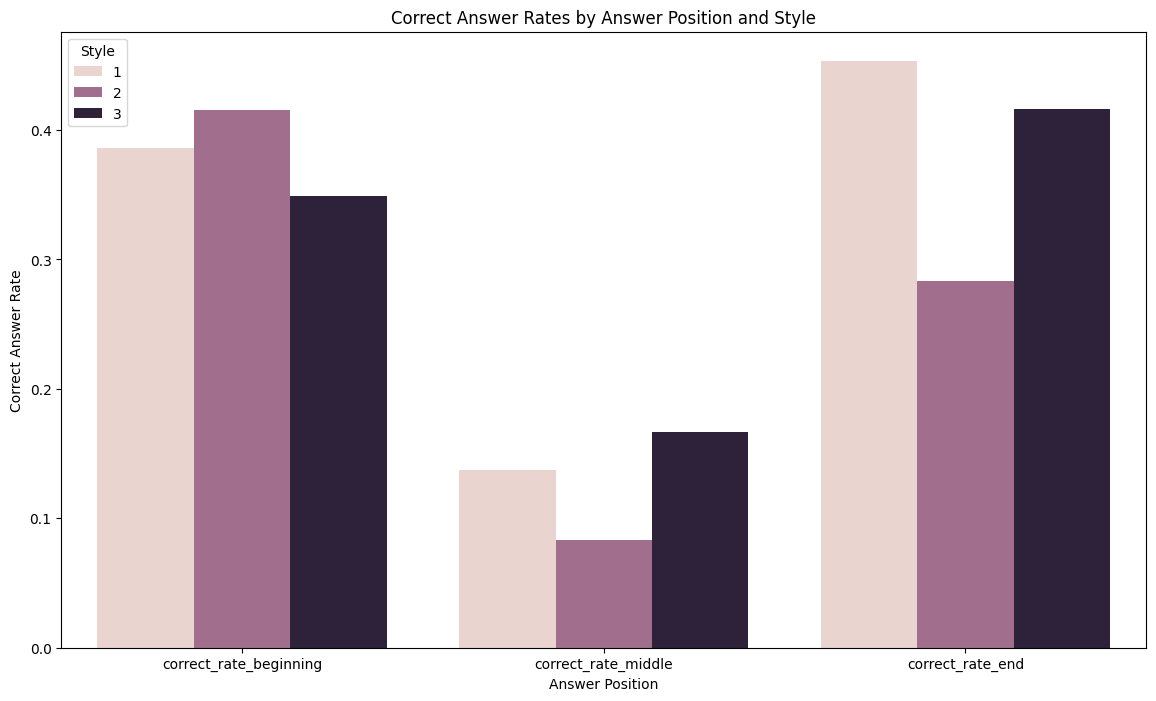

In [7]:
plt.figure(figsize=(14, 8))
sns.barplot(x='position', y='correct_rate', hue='style', data=melted_df, ci=None)
plt.title('Correct Answer Rates by Answer Position and Style')
plt.xlabel('Answer Position')
plt.ylabel('Correct Answer Rate')
plt.legend(title='Style')
plt.show()